In [138]:
if True:
  import nltk
  import re
  import os
  import pandas as pd
  import numpy as np
  import scipy.sparse as sp
  import lightgbm as lgb
  import scipy.sparse as sp

  from sklearn.preprocessing import LabelEncoder
  from sklearn.model_selection import StratifiedKFold
  from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
  from sklearn.linear_model import LogisticRegression, SGDClassifier
  from sklearn import metrics
  from sklearn.metrics import f1_score
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, classification_report
  from urllib.parse import unquote, urlparse, quote
  from sklearn.feature_extraction.text import TfidfVectorizer
  from tqdm import tqdm

  import warnings
  warnings.filterwarnings('ignore')

  import seaborn as sns
  import matplotlib.pyplot as plt
  from matplotlib.ticker import PercentFormatter
  from matplotlib.pyplot import MultipleLocator
  %matplotlib inline

  from pandas.api.types import is_datetime64_any_dtype as is_datetime
  from pandas.api.types import is_categorical_dtype
  import random
  import math

In [141]:
def reduce_mem_usage(df, use_float16=False):
  """
  遍历数据帧的所有列并修改数据类型以减少内存使用。
  """

  start_mem = df.memory_usage().sum() / 1024**2
  print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

  for col in df.columns:
    if is_datetime(df[col]) or is_categorical_dtype(df[col]):
      continue
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      if str(col_type)[:3] == "int":
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
    else:
      df[col] = df[col].astype("category")

  end_mem = df.memory_usage().sum() / 1024**2
  print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
  print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

  return df

In [142]:
# 数据读取
train = pd.read_csv('./data/dataTrain.csv')
no_label = pd.read_csv('./data/dataNoLabel.csv')
test = pd.read_csv('./data/dataA.csv')

print(f'original train dataset size: {len(train)}')

if True:
  # 剔除最后1w个样本
  train = train[:math.ceil(len(train)*0.83)]
else:
  # 剔除可能是假的样本
  fake_rows = train[train['id'] > 170000].index.tolist()
  train.drop(fake_rows, inplace=True)
print(f'train dataset size: {len(train)}')

original train dataset size: 59872
train dataset size: 49694


In [143]:
# 类别特征列
categorical_f = ['f1','f2','f3']
categorical_f = []

# 抛弃的特征列
drop_f = ['f11','f16','f27','f28','f40','f41']
# drop_f = []
train.drop(drop_f, axis=1, inplace=True)
test.drop(drop_f, axis=1, inplace=True)

# 保留的原始特征列
original_f = [i for i in train.columns if i not in ['id','label']]

# 数据拼接
data = pd.concat([train, test]).reset_index(drop=True)
data['f3'] = data['f3'].map({'low': 0, 'mid': 100, 'high': 10000}) # 2 4 6

In [144]:
# 加入frequency编码
if False:
  for col in tqdm(original_f):
    if col not in ['label', 'id']:
      data[col + '_cnt'] = data[col].map(data[col].value_counts())
  data.head()

In [145]:
# 数据简单处理
for i in original_f:
  data[i] = data[i] + 1

In [146]:
data['f1_f2'] = data['f1']*10 + data['f2']
data['f4+f5+f6'] = data['f4'] + data['f5'] + data['f6']
data['f4*f5*f6'] = data['f4'] * data['f5'] * data['f6']
data['f4/f5/f6'] = data['f4'] / data['f5'] / data['f6']
data['f4-f5-f6'] = data['f4'] - data['f5'] - data['f6']

cf = ['f4', 'f5', 'f6']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]

cf = ['f43', 'f44', 'f45', 'f46']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]

cf = ['f13', 'f14']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]

In [147]:
cf = ['f26', 'f30']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f25', 'f18']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f13', 'f17']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f30', 'f37']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f18', 'f24']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f18', 'f37']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f19', 'f30']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f23', 'f24', 'f30']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

cf = ['f7', 'f8']
for i in range(len(cf)):
  for j in range(i + 1, len(cf)):
    data[f'{cf[i]}+{cf[j]}'] = data[cf[i]] + data[cf[j]]
    data[f'{cf[i]}-{cf[j]}'] = data[cf[i]] - data[cf[j]]
    data[f'{cf[i]}*{cf[j]}'] = data[cf[i]] * data[cf[j]]
    data[f'{cf[i]}/{cf[j]}'] = data[cf[i]] / data[cf[j]]
    data[f'{cf[i]}_{cf[j]}'] = data[cf[i]] * 1000 + data[cf[j]]

In [148]:
# 数据简单处理
for i in original_f:
  data[i] = data[i] - 1

In [149]:
# 内存压缩
# reduce_mem_usage(data)

# 训练测试分离
train = data[~data['label'].isna()].reset_index(drop=True)
test = data[data['label'].isna()].reset_index(drop=True)

In [150]:
# 特征筛选
features = [i for i in train.columns if i not in ['label', 'id']]
print(f'num featrues: {len(features)}')

num featrues: 140


In [151]:
# 参数设定
y = train['label']
n_fold = 5;
KF = StratifiedKFold(n_splits=n_fold, random_state=2023, shuffle=True)
params = {
  'objective': 'binary',
  'boosting_type': 'gbdt',
  'metric': 'auc',
  'n_jobs': 30,
  'learning_rate': 0.004,
  'num_leaves': 31,
  # 'num_leaves': 2 ** 6, # 太多效果不好
  'max_depth': 6,
  'tree_learner': 'serial',
  'colsample_bytree': 0.8,
  'subsample_freq': 1,
  'subsample': 0.8,
  'num_boost_round': 3000,
  'max_bin': 255,
  'verbose': -1,
  'seed': 2022,
  'bagging_seed': 2022,
  'feature_fraction_seed': 2022,
  'early_stopping_rounds': 1000
}

# 记录特征重要性
feat_imp = pd.DataFrame({'feat': features, 'imp': 0})
feat_gain = pd.DataFrame({'feat': features, 'gain': 0})

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros((len(test)))

# 模型训练
for fold, (trn_idx, val_idx) in enumerate(KF.split(train.values, y.values)):
  print(f'- Fold: {fold+1}')
  trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=y.iloc[trn_idx], categorical_feature=categorical_f)
  val_data = lgb.Dataset(train.iloc[val_idx][features], label=y.iloc[val_idx], categorical_feature=categorical_f)
  num_round = 3000
  clf = lgb.train(
    params,
    trn_data,
    num_round,
    valid_sets=[trn_data, val_data],
    verbose_eval=700,
    early_stopping_rounds=100
  )
  print('\n')

  oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
  predictions_lgb[:] += clf.predict(test[features], num_iteration=clf.best_iteration) / n_fold

  feat_imp['imp'] += clf.feature_importance() / n_fold
  feat_gain['gain'] += clf.feature_importance(importance_type='gain') / n_fold

auc = roc_auc_score(y, oof_lgb)
print('\nacu: %.12f' % auc)

- Fold: 1
Training until validation scores don't improve for 1000 rounds
[700]	training's auc: 0.918014	valid_1's auc: 0.90951
[1400]	training's auc: 0.926821	valid_1's auc: 0.910882
[2100]	training's auc: 0.932813	valid_1's auc: 0.910988
[2800]	training's auc: 0.938161	valid_1's auc: 0.910709
Early stopping, best iteration is:
[1929]	training's auc: 0.93143	valid_1's auc: 0.911087


- Fold: 2
Training until validation scores don't improve for 1000 rounds
[700]	training's auc: 0.918953	valid_1's auc: 0.905681
[1400]	training's auc: 0.927741	valid_1's auc: 0.907079
[2100]	training's auc: 0.933757	valid_1's auc: 0.907115
[2800]	training's auc: 0.939151	valid_1's auc: 0.906896
Did not meet early stopping. Best iteration is:
[3000]	training's auc: 0.940555	valid_1's auc: 0.90683


- Fold: 3
Training until validation scores don't improve for 1000 rounds
[700]	training's auc: 0.917407	valid_1's auc: 0.913561
[1400]	training's auc: 0.926439	valid_1's auc: 0.914392
[2100]	training's auc: 0.932

In [152]:
import time
import datetime
import pytz as pytz
tz = pytz.timezone('Asia/Shanghai')
t = datetime.datetime.fromtimestamp(int(time.time()), tz).strftime('%m-%d %H:%M')
print(t)

11-09 10:08


In [153]:
# 导出预测结果
test['label'] = predictions_lgb
test[['id', 'label']].to_csv(f'./{auc}.csv', index=False)

In [154]:
feat_imp = feat_imp.sort_values(by='imp', ascending=False)
feat_imp.to_csv('f_importance.csv', index=False)

feat_gain = feat_gain.sort_values(by='gain', ascending=False)
feat_gain.to_csv( 'f_gain.csv', index=False)

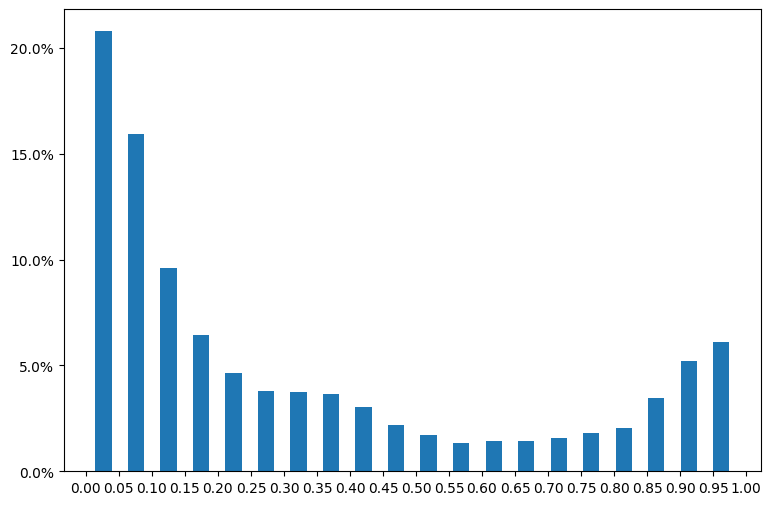

In [155]:
col = test['label']
plt.figure(figsize=(9,6))
x_major_locator=MultipleLocator(0.05)
y_major_locator=MultipleLocator(0.05)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.hist(col, bins=20, rwidth=0.5, weights=np.ones(len(col)) / len(col))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [156]:
idx = test['label'] > 0.95
print(f'>0.95 {len(test[idx])}')

idx = test['label'] > 0.96
print(f'>0.96 {len(test[idx])}')

idx = test['label'] > 0.97
print(f'>0.97 {len(test[idx])}')

idx = test['label'] > 0.98
print(f'>0.98 {len(test[idx])}')

>0.95 2048
>0.96 1194
>0.97 471
>0.98 48


In [157]:
if False:
  test_cpy = test.copy()
  threshold = 0.96
  idx = test_cpy['label'] > threshold
  print(f'{len(test_cpy[idx])}')
  test_cpy.loc[idx, 'label'] = threshold
  
  test_cpy[['id', 'label']].to_csv('./%.12f_truncated%.2f.csv' % (auc, threshold), index=False)

In [158]:
if True:
  test_cpy = test.copy()
  test_cpy['label'] = test_cpy['label'] * 1.0001
  test_cpy[['id', 'label']].to_csv('./%.12f_shifted%.7f.csv' % (auc, 1.0001), index=False)